In [1]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import logger
import xesmf as xe
from scipy.ndimage import label

import climtas.nci
from dask.distributed import Client, as_completed

In [2]:
LOG = logger.get_logger(__name__)

In [3]:
client = Client(
    n_workers=1,
    threads_per_worker=24
)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42379,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:37309,Total threads: 24
Dashboard: /proxy/37007/status,Memory: 95.00 GiB
Nanny: tcp://127.0.0.1:40139,


In [4]:
def get_hba_data(date):

    date_dt = datetime.strptime(date, "%m-%Y")
    year = date_dt.strftime("%Y")
    month = date_dt.strftime("%m")
    
    ##### Himawari Data
    if date_dt <= datetime.strptime('2019-03-31', '%Y-%m-%d'):
        version = 'v1.0'
    else:
        version = 'v1.1'
    directory=Path(f'/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/{version}/{year}/{month}')
    files = sorted(str(p) for p in directory.rglob("*23[0-5][0].nc"))
    def _preprocess(ds):
        return ds.surface_global_irradiance.sel(latitude=-42.88, longitude=147.32)
    
    return xr.open_mfdataset(
        files,
        combine='by_coords',
        preprocess=_preprocess,
    )

In [5]:
data = []
years = [
    '2016',
    '2017',
    '2018',
    '2019',
    '2020',
    '2021',
    '2022',
    '2023',
    '2024',
    '2025',
]
months = ['12', '01', '02']
if __name__ == '__main__':
    futures = {}
    for year in years:
        if year == '2025':
            months = ['01']
        for month in months:
            date = f'{month}-{year}'
            future = client.submit(get_hba_data, date)
            futures[future] = f"The job for {date}"
    for future in as_completed(futures):
        result = future.result()
        data.append(result)
ds = xr.concat(data, dim='time')

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [6]:
ds.load()

<xarray.Dataset> Size: 81kB
Dimensions:                    (time: 5061)
Coordinates:
  * time                       (time) datetime64[ns] 40kB 2022-01-31T23:00:00...
    latitude                   float32 4B -42.88
    longitude                  float32 4B 147.3
Data variables:
    surface_global_irradiance  (time) float64 40kB 676.1 703.5 ... 896.9 917.9

In [13]:
ds = ds.sortby('time')


In [16]:
import matplotlib.pyplot as plt

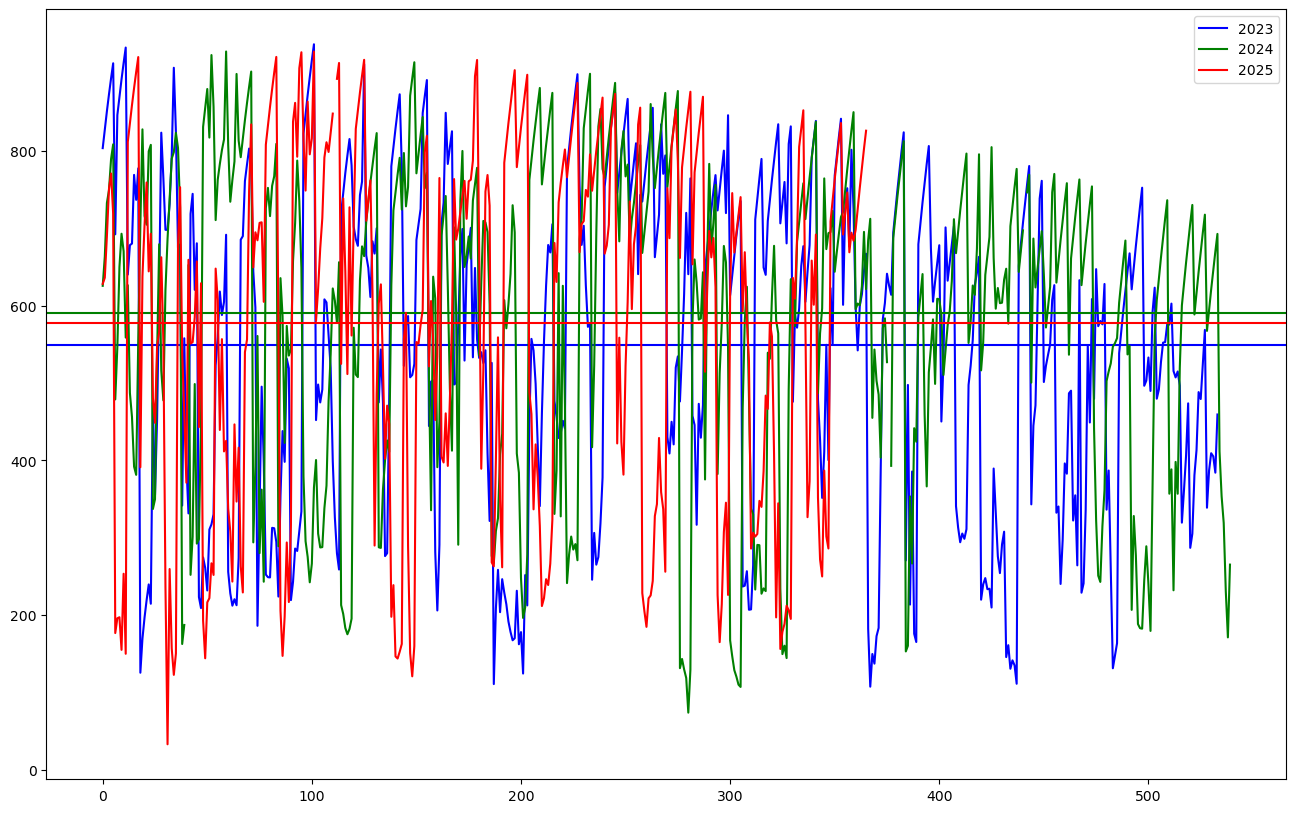

In [35]:
plt.figure(figsize=(16,10))
seasons = [
    # ('2016','2017'),
    # ('2017','2018'),
    # ('2018','2019'),
    # ('2019','2020'),
    # ('2020','2021'),
    # ('2021','2022'),
    ('2022','2023'),
    ('2023','2024'),
    ('2024','2025'),
]
clim = []
for season in seasons:
    start = season[0]
    end = season[1]
    data = ds.sel(time=slice(f'{start}-12', f'{end}-02')).surface_global_irradiance.values

    if end == '2025':
        color='red'
        alpha=1
    elif end == '2024':
        color='green'
    else:
        color='blue'
        alpha=1
    
    plt.plot(data, color=color, alpha=alpha, label=end)
    plt.axhline(np.nanmean(data), color=color)
    plt.legend()